# GIS GZ – Übung 6: Geoprocessing mit Netzwerken <span style="color:red">(Musterlösung)</span>

## Einleitung
In den letzten beiden Wochen haben Sie gelernt, wie Sie Geodaten mit Fiona und mit Rasterio verarbeiten können. Worauf wir heute fokussieren werden, sind Netzwerkdaten, die wir mithilfe der library NetworkX verarbeiten werden. Dabei schauen wir den **Least Cost Path**-Algorithmus genauer an, da viele Implementierungen die aus der Vorlesung bekannte Bewegungsmatrix verwenden, bei der jede Zelle mit seinen 8 Nachbarzellen verbunden wird. Es können jedoch auch komplexere Bewegungsmatrizen definiert werden. Zum Beispiel können auch "Springer"-Bewegungen modelliert werden. In dieser Übung werden wir untersuchen, welchen Einfluss dies auf das Resultat des least cost paths hat. Wir verwenden in diesem Notebook daher die Python libraries `rasterio` und `NetworkX`.

* In diesem Notebook ist der Least Cost Path Algorithmus bereits implementiert.
* In dieser Übung geht es darum, verschiedene Bewegungsmatrizen auszuprobieren. Sie müssen dazu in diesem Notebook lediglich den `lattice` anpassen, den Sie dann der Funktion `calc_least_cost_path()` übergeben können.
* **Gehen Sie das Notebook aufmerksam durch und versuchen Sie den Code detailliert zu verstehen.**

**Tipp**
* Wenn das Output einer Zelle des Notebooks zu gross ist, können Sie die Output-Zellen folgendermassen vergrössern: Cell > All outputs > Toggle Scrolling

### Grobziele
* Sie können Daten in Netzwerken speichern und Netzwerkoperationen durchführen. 

### Feinziele
* Sie können eine least cost path-Analyse mit open libraries durchführen.
* Sie können eine Bewegungsmatrix für die nächsten 24 Zellen (5x5-Matrix im zweidimensionalen Fall; R=2) einer Zentrumszelle erstellen und mathematisch erklären.
* Sie können erklären, wie die Findung des least cost paths algorithmisch funktioniert und was es dazu braucht.
* Sie können den vorgegebenen Python-Code korrekt interpretieren.

### Projekt
* Sie arbeiten an der Lösung Ihrer Fragestellung und wenden die erlernten Techniken aktiv an. 
* Sie können weitere Werkzeuge von NetworkX auf Ihr Projekt anwenden (z.B. anderen Netzwerktyp definieren oder `maximum_flow` anwenden).

## Vorbereitungen 

### Importieren der nötigen libraries

In [1]:
import os
import time
import rasterio
from shapely.geometry import LineString, mapping
from shapely.geometry.geo import box
import networkx as nx
import numpy as np
from collections import OrderedDict
import fiona
from fiona.crs import from_epsg
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import rasterio.plot as rplot

### Konstanten definieren

In [2]:
# Three points are given: start and end point A and B (full extent) and T for a transition station (short distance)
point_a = (2660882, 1172607)
point_b = (2668032, 1218500)
point_t = (2662122, 1212284)
crs_used = 2056  # EPSG-Code von LV95

### Szenarien definieren
Wählen Sie eines der drei folgenden Szenarien aus: 
* `transition_station`
* `full_extent_with_costs`
* `full_extent_with_slope`

Beginnen Sie dabei mit dem obersten, da das Studiengebiet am kleinsten ist und benutzen Sie dieses zum Debuggen. Wechseln Sie zu den unteren zwei Szenarien, sobald alles funktioniert. Das zweite und dritte Szenario bilden einen möglichen Planungsraum zwischen Innertkirchen und Mettlen ab und basieren auf folgenden Kostenoberflächen:
* `input_cost_surface_corridor.tif`: Ein Kostenraster, das durch die Überlagerung unterschiedlicher Polygone mit unterschiedlichen Gewichtungen erstellt wurde. Je höher der Wert, desto höher die Durchdringungskosten.
* `input_slope_corridor.tif`: Die Steigung pro Pixel im Untersuchungsgebiet. Je steiler, desto höher die Kosten.

In [3]:
# Select one scenario by choosing one of the following here:
# * transition_station (ca. 12 sec)
# * full_extent_with_costs (ca. 1.25 min)
# * full_extent_with_slope (ca. 1.25 min)

# Start with the transition station scenario, until the logic and all the functions work, then
# select a full extension scenario. The random cost surface scenarios are just for analyzing the difference between
# different resolutions. Don't use the optimization approach with Gurobi on them, as this would take too long.
scenario = 'transition_station'

source_coord = None
target_coord = None
data_directory = None
input_cost_raster = None
input_study_area = None
input_restriction_area = None

if scenario == 'transition_station':
    source_coord = point_b
    target_coord = point_t
    data_directory = os.path.join(os.path.abspath(''), 'data')
    input_cost_raster = os.path.join(data_directory, 'input_cost_surface_small.tif')
    input_study_area = os.path.join(data_directory, 'input_study_area_small.shp')
    input_restriction_area = None
elif scenario == 'full_extent_with_costs':
    source_coord = point_a
    target_coord = point_b
    data_directory = os.path.join(os.path.abspath(''), 'data')
    input_cost_raster = os.path.join(data_directory, 'input_cost_surface_corridor.tif')
    input_study_area = os.path.join(data_directory, 'input_study_area_corridor.shp')
    input_restriction_area = None
elif scenario == 'full_extent_with_slope':
    source_coord = point_a
    target_coord = point_b
    data_directory = os.path.join(os.path.abspath(''), 'data')
    input_cost_raster = os.path.join(data_directory, 'input_slope_corridor.tif')
    input_study_area = os.path.join(data_directory, 'input_study_area_corridor.shp')
    input_restriction_area = None

### Ausgabeordner definieren und erstellen, falls nicht vorhanden. 

In [4]:
# Define the current directory in which the output files should be written. Create it if it should not exist.
out_base_path = os.path.join(os.path.abspath(''), 'output_files')
if not os.path.exists(out_base_path):
    os.mkdir(out_base_path)

out_dir = os.path.join(out_base_path, scenario)
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

## Umsetzung mit NetworkX

Nun setzen wir den least cost path Algorithmus mit der graph library NetworkX um. Dieser Ansatz erlaubt Ihnen maximale Freiheit beim Erstellen der Suchmatrix (engl.: _lattice_), welche die Nachbarzellen umfasst, durch welche der least cost path verlaufen soll. 

### Standardmatrix definieren
Die Standardmatrix (nach der Königinnenfigur im Schach auch *Queen's pattern* gennant) mit der Zentrumszelle und den acht Nachbarn (3x3-Matrix; R=1 in der Abbildung unten) kennen Sie aus der Vorlesung. Für diese Übung wurde folgende Datenstruktur für die Definition der Bewegungen von der Zentrumszelle zu den acht angrenzenden Zellen definiert:

In [5]:
default_lattice = [[((0, 0), 1.0 / 2.0), (( 0,  1), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), (( 1,  0), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), ((-1,  0), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), (( 0, -1), 1.0 / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), ((-1,  1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), (( 1,  1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), ((-1, -1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), (( 1, -1), np.sqrt(2) / 2.0)]
                  ]


Die Datenstruktur von `default_lattice` ist folgendermassen aufgebaut:
* `default_lattice` ist eine Liste von Listen: `[["liste1"], ["liste2"], ["liste3"], ...]`
* Jede dieser Listen speichert dabei eine Bewegung.
* Jede Liste besteht aus einer Sequenz von Tuples.
* Jedes Tuple hat dabei folgende Form `((x, y), w)`. Dabei ist x und y jeweils der Abstand zur Ausgangszelle `(0, 0)` in x, beziehungsweise y Richtung und `w` dass Gewicht der Zelle. Bei der oben definierten `default_lattice` sind dabei die Gewichte entweder $\frac{1}{2}$ oder $\frac{\sqrt{2}}{2}$ - je nachdem, ob Sie sich horizontal/vertikal (Turmfigur im Schach) oder diagonal (Läuferfigur im Schach) bewegen. 

<img src="images/knotenreisekosten.png">

Aus der Vorlesung kennen sie das Beispiel für die Bewegung **a1**. Dieser kann folgendermassen abgebildet werden:

```python
[((0, 0), 1.0 / 2.0), ((1, 0), 1.0 / 2.0)]
```

Die Länge einer Bewegung kann dabei beliebig lang sein. In folgendem Beispiel führt die Bewegung zwei Zellen nach rechts, statt nur einer Zelle wie bei der Bewegung **a1** im vorherigen Beispiel. 
```python
[((0, 0), w1), ((1, 0), w2), ((2, 0), w3)]
```

In folgender Grafik sind alle möglichen Bewegungen dargestellt. Die schwarzen Dreiecke stellen die diagonalen Bewegungen dar, die grauen Quadrate die horizontalen, respektive vertikalen Bewegungen.

<img src="images/lattices_r1.png" style='height: 200px;'>


#### Verständnisaufgabe
Erklären Sie Ihrem/Ihrer Nachbar/in, wie diese Gewichtungen zustande kommen. 

### Bewegungsmatrizen plotten

Mit der folgenden Funktion können Sie die in `default_lattice` definierten Bewegungen visualisieren. Die Zahlen in den Graphen geben jeweils die Gewichtung pro Zelle für die jeweilige Bewegung an. Diese Visualisierung kann Ihnen beim Überprüfen ihrer Lattice helfen.

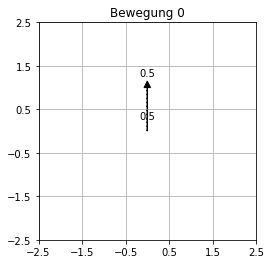

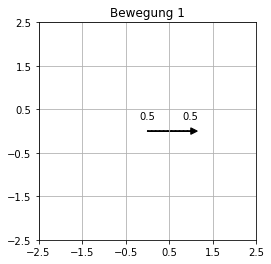

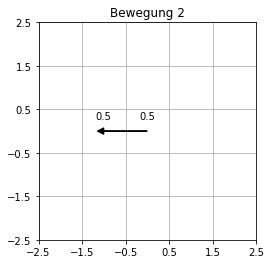

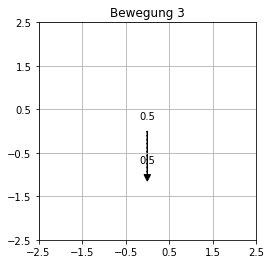

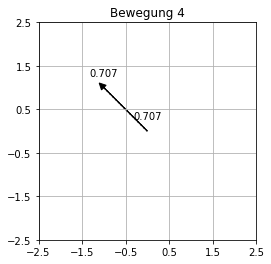

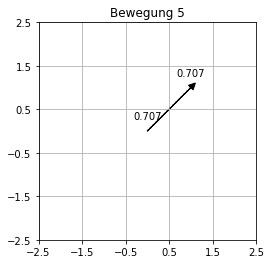

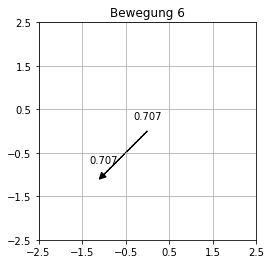

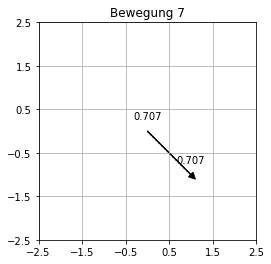

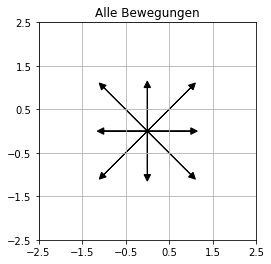

In [6]:
def plot_lattice(lattice):
    # Plot all links
    for i, e in enumerate(lattice):
        fig, ax = plt.subplots()
        ax.set_title("Bewegung {}".format(i))

        ax.plot([s[0][0] for s in e], [s[0][1] for s in e], ls=':', color='k')
        ax.arrow(e[0][0][0], e[0][0][1], e[-1][0][0], e[-1][0][1], head_width=0.15, head_length=0.15, fc='k', ec='k')

        for s in e:
            w = s[1]
            x = s[0][0]
            y = s[0][1]
            ax.text(x,
                    y + 0.45,
                    '{}'.format(round(w, 3)),
                    horizontalalignment='center',
                    verticalalignment='top')

        ax.set_aspect('equal')
        ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(-3.5, 3.5, 1)))
        ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(-3.5, 3.5, 1)))
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)

        ax.grid(True, which='major')

        plt.show()
        plt.close()

    # Plot all links
    fig, ax = plt.subplots()
    ax.set_title("Alle Bewegungen")
    for i, e in enumerate(lattice):
        ax.arrow(e[0][0][0], e[0][0][1], e[-1][0][0], e[-1][0][1], head_width=0.15, head_length=0.15, fc='k', ec='k')
    ax.set_aspect('equal')
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(-3.5, 3.5, 1)))
    ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(-3.5, 3.5, 1)))
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)

    ax.grid(True, which='major')

    plt.show()
    plt.close()

plot_lattice(default_lattice)

### Zusatzfunktionen definieren

Wir brauchen noch zwei Funktionen, die uns die berechneten least cost paths darstellen oder in einer Datei abspeichern. Die `calc_least_cost_path()`-Funktion wurde so gestaltet, dass zwei Outputs generiert werden:
* die __totalen Kosten__ des least cost paths und
* ein __LineString-Objekt__ mit den Koordinaten der Stützpunkte des least cost paths (welches dasselbe CRS wie das ursprüngliche Raster verwendet, in unserem Fall EPSG:2056 / LV95)

#### Darstellen des LineString-Objekts mit matplotlib

In [7]:
def plot_result(ls, cost_surface=None, cost_surface_polygon=None, restricted_area=None):
    """
    Plots the LineString object by using Rasterio plot
    
    Args:
        ls (LineString): The LineString object of the least cost path
        cost_surface (str): The path to the cost surface that should be displayed
        cost_surface_polygon (Polygon): The Polygon object that should be displayed
        restricted_area (str): The path to the restricted area that should be displayed

    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if cost_surface is not None:
        with rasterio.open(cost_surface) as src:
            rplot.show(src, ax=ax, zorder=10)

    if cost_surface_polygon is not None:
        rplot.show(cost_surface_polygon, ax=ax, zorder=10)

    if restricted_area is not None:
        ax.add_patch(PolygonPatch(restricted_area,
                                  fc='red',
                                  ec='red',
                                  alpha=0.5,
                                  zorder=100))

    x, y = ls.xy
    ax.plot(x, y,
            color='k',
            alpha=0.7,
            linewidth=3,
            solid_capstyle='round',
            zorder=1000)

    plt.show()
    return

#### Speichern des Line-String-Objekts als GeoJSON

In [8]:
def write_line_to_json(dst_path, linestring_object, crs_epsg_nr, costs):
    """
    Writes a single point to a shapefile
    
    Args:
        dst_path (str): The full path to which the shapefile should be written
        linestring_object (LineString): A linestring object representing the LCP
        crs_epsg_nr (int): The coordinates' EPSG number of their CRS
        costs (float): The total path costs according to the accumulated cost surface

    """

    # Replace the ending in every case to '.json
    dst_path = dst_path.rsplit('.', 1)[0] + '.geojson'

    with fiona.open(dst_path,
                    'w',
                    driver='GeoJSON',
                    crs=from_epsg(crs_epsg_nr),
                    schema={
                        'geometry': 'LineString',
                        'properties': OrderedDict([
                            ('costs', 'float')
                        ])
                    }) as dst:
        dst.write({
            'geometry': mapping(linestring_object),
            'properties': OrderedDict([
                ('costs', costs)
            ])
        })

    print("")
    print("Exported file to {}".format(dst_path))
    print("")

    return

### Least Cost Path

Folgend sehen Sie die Hauptfunktion zur Ermittlung des least cost paths und seiner aufaddierten, totalen Kosten.

Die Funktion öffnet zuerst mittels der Library `rasterio` eine Rasterdatei. Danach iteriert die Funktion über alle Zellen dieses Rasters und erstellt mittels des übergebenen Lattice ein networkx Graph Objekt. Dieses Graph objekt wird dann verwendet um den least cost Pfad zu finden. In "kurzform" wird ein solches Graph Objekt folgendermassen erstellt:

```Python
# Import library
import networkx as nx

# Create a directional graph object 
G = nx.DiGraph()

_edges = []
_edges.append(("A", "B", 5.0))
_edges.append(("A", "C", 5.0))

# Add edges to Graph
G.add_weighted_edges_from(_edges)

# Find shortest path
nx.single_source_dijkstra(G, source="A", target="C")
```

In [9]:
def calc_least_cost_path(path, band=1, source_coord=(0, 0), target_coord=(0, 0), matrix=default_lattice):
    """
    Create a graph with the weighted edges based on the cost surface and compute the least cost path
    
    Args:
        path (str): Path to the input raster file that represents the cost surface
        band (int): The band of the raster file that contains the cost values
        source_coord (tuple): The coordinate pair of the source point, given in the same CRS as the cost surface
        target_coord (tuple): The coordinate pair of the target point, given in the same CRS as the cost surface
        matrix (list): The lattice (search kernel) used to determine the least cost neighbors
        
    
    Returns:
        The total costs and a LineString object of the least cost path
    """

    # Open Raster
    with rasterio.open(path) as src:

        fwd = src.transform
        data = src.read(band)
        NODATA = src.meta['nodata']

        print("-- Create Graph --")
        G = nx.DiGraph()


        # Create edges
        _edges = []

        for i in range(src.width):
            for j in range(src.height):

                for edge in matrix:

                    (start_i, start_j), _ = edge[0]
                    start_node = (start_i + i, start_j + j)

                    (end_i, end_j), _ = edge[-1]
                    end_node = (end_i + i, end_j + j)

                    # We only consider edges within the study area that have a value
                    if ((0 <= start_node[0] < src.width and 0 <= start_node[1] < src.height) and
                            (0 <= end_node[0] < src.width and 0 <= end_node[1] < src.height) and
                            (not data[j, i] == NODATA)):

                        # Calculate cost of edge
                        cost = 0.0
                        has_nodata = False
                        for k in edge:
                            (k_i, k_j), w_k = k
                            d = data[k_j + j, k_i + i]
                            if d == NODATA:
                                has_nodata = True
                                break
                            cost += d * w_k

                        if not has_nodata:
                            _edges.append((start_node, end_node, cost))

        G.add_weighted_edges_from(_edges)

        print("")
        print("\t Created graph with:")
        print("\t # Vertex: {}".format(G.number_of_nodes()))
        print("\t # Edges: {} ".format(G.number_of_edges()))
        print("")

        # Find shortest path and return total cost and LineString of found path
        print("-- Find shortest path --")
        source_node = tuple(map(int, ~fwd * source_coord))
        target_node = tuple(map(int, ~fwd * target_coord))

        tot_cost, path = nx.single_source_dijkstra(G,
                                                   source=source_node,
                                                   target=target_node,
                                                   weight='weight')

        _coords = []
        for p in path:
            # We add 0.5 to p to get coordinate of middle of corresponding cell
            x, y = fwd * (p[0] + 0.5, p[1] + 0.5)
            _coords.append((x, y))

        ls = LineString(_coords)

        print("")
        print("\t Found path with:")
        print("\t\t # Path costs: {}".format(tot_cost))
        print("\t\t # Path length: {} ".format(ls.length))
        print("")
        
        plot_result(ls, cost_surface=input_cost_raster)

    return tot_cost, ls

### Aufgabe 1: Leat Cost Path mit default lattice

Führen Sie das Notebook aus. Wie lange braucht der Code, um das Resultat mit der 3x3-Suchmatrix zu berechnen?

-- START LEAST COST PATH ANALYSIS WITH QUEEN'S PATTERN (R=1) --
-- Create Graph --

	 Created graph with:
	 # Vertex: 7486
	 # Edges: 58604 

-- Find shortest path --

	 Found path with:
		 # Path costs: 23271.567409381554
		 # Path length: 11498.275605729697 



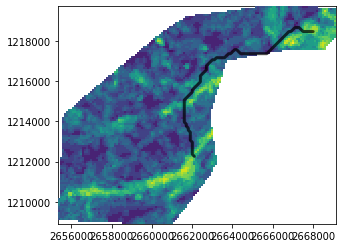


Exported file to Y:\teaching\GIS_GZ\HS19\uebungen\uebung_06\output_files\transition_station\networkx_lcp_for_cost_surface_r1_pattern.geojson

The LCP analysis with the queen's pattern took 1.76 seconds.




In [10]:
# Start LCP analysis with queen's pattern
time_0 = time.time()
print("-- START LEAST COST PATH ANALYSIS WITH QUEEN'S PATTERN (R=1) --")
tot_cost, ls = calc_least_cost_path(path=input_cost_raster,
                                    band=1,
                                    source_coord=source_coord,
                                    target_coord=target_coord,
                                    matrix=default_lattice)

write_line_to_json(dst_path=os.path.join(out_dir, 'networkx_lcp_for_cost_surface_r1_pattern.geojson'),
                   linestring_object=ls,
                   crs_epsg_nr=crs_used,
                   costs=tot_cost)
time_elapsed = round(time.time() - time_0, 2)
print("The LCP analysis with the queen's pattern took {} seconds.".format(time_elapsed))
print('\n')

### Aufgabe 2

Wir haben oben das Queen's pattern definiert (3x3-Matrix mit einer Zentrumszelle und 8 Nachbarn). Erweitern Sie nun die Suchmatrix so, dass auch die Springerbewegungen berücksichtigt werden (R=2 im Bild unten). Was bedeutet das konkret für die Gewichtungen und für die Zellen, die dabei beigezogen werden müssen? Skizzieren Sie den Ansatz und verwenden Sie dabei grundlegende Methoden der Geometrie wie z.B. den Strahlensatz und den Satz des Pythagoras. Denken Sie daran, dass die Funktion oben verlangt, dass das _erste_ und das _letzte_ Tupel einer Zeile den Start- und den Endpunkt definieren. Die Tupels dazwischen stellen also alle anderen Zellen dar, die zur Berechnung der "Sprungkosten" von A nach B mitberücksichtigt werden.

Alternativ können Sie sich die Gewichte auch mit der Library [shapely](https://shapely.readthedocs.io/en/stable/manual.html) berechnen. (z.B. mittels [LineString()](https://shapely.readthedocs.io/en/stable/manual.html#LineString), [box()](https://shapely.readthedocs.io/en/stable/manual.html#shapely.geometry.box), [intersection()](https://shapely.readthedocs.io/en/stable/manual.html#object.intersection) und length) 

Übergeben Sie dann die erweiterte Suchmatrix der Funktion und analysieren Sie, inwieweit sich die Resultate voneinander unterscheiden.

__Tipp__: Sie müssen nur die neuen Sprünge (also die, die im Bild unten schwarz markiert sind) in einem neuen Suchnetz definieren – analog zum Vorgehen weiter oben (siehe dazu leere eckige Klammer im Code unten). Summieren Sie dann die beiden Suchnetze (lattices) auf und verwenden Sie das neue Suchnetz für dieselbe Analyse. 

__Tipp__: Eigentlich müssen Sie nur eine Bewegung genau modellieren. Die restlichen sieben Bewegungen ergeben sich durch geschicktes Austauschen von Vorzeichen oder Ordinaten. 

<img src="images/lattices_r2.png" style='height: 200px;'>

### <span style="color:orange">Folgend finden Sie das erweiterte Suchmuster (lattice), das Sie zum bestehenden Basismuster hinzufügen:</span>

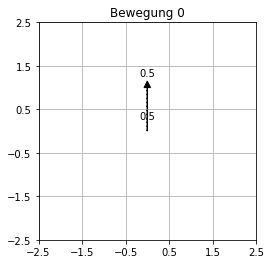

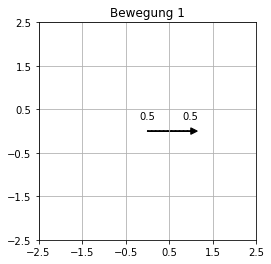

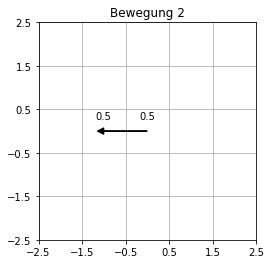

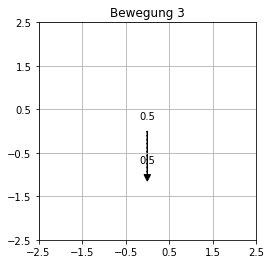

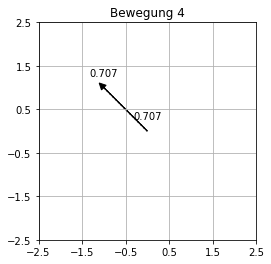

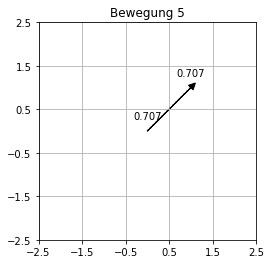

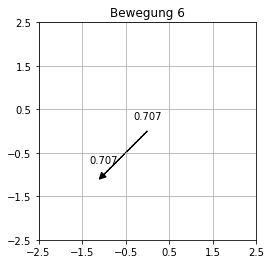

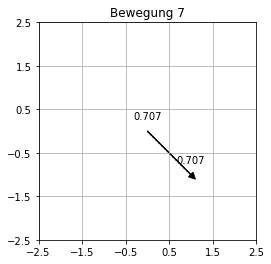

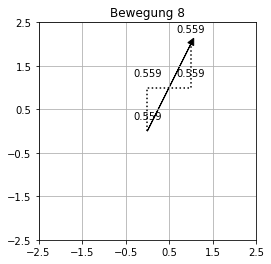

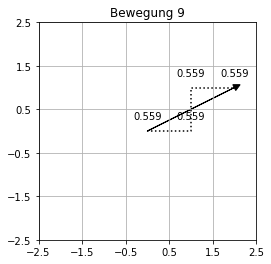

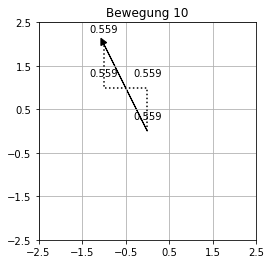

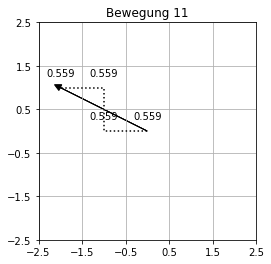

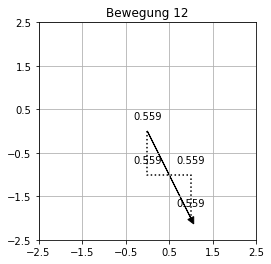

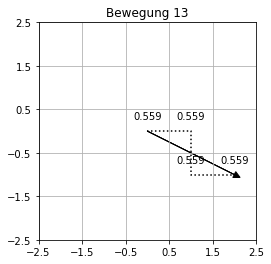

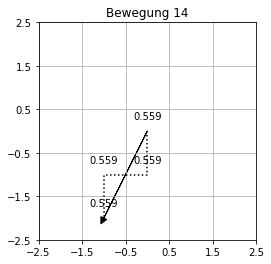

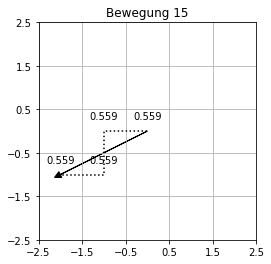

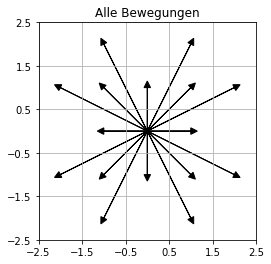

-- START LEAST COST PATH ANALYSIS WITH EXTENED PATTERN --
-- Create Graph --

	 Created graph with:
	 # Vertex: 7486
	 # Edges: 115932 

-- Find shortest path --

	 Found path with:
		 # Path costs: 22839.339976514042
		 # Path length: 11059.141723508461 



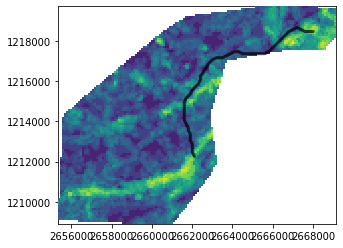


Exported file to Y:\teaching\GIS_GZ\HS19\uebungen\uebung_06\output_files\transition_station\networkx_lcp_for_cost_surface_extended_pattern.geojson

The LCP analysis with the extended pattern took 3.33 seconds.




In [11]:
# Define all addiitonal movements
knight_lattice = [(((0, 0), 0.25 * np.sqrt(5)), ((0, 1), 0.25 * np.sqrt(5)), ((1, 1), 0.25 * np.sqrt(5)), ((1, 2), 0.25 * np.sqrt(5))),
               (((0, 0), 0.25 * np.sqrt(5)), ((1, 0), 0.25 * np.sqrt(5)), ((1, 1), 0.25 * np.sqrt(5)), ((2, 1), 0.25 * np.sqrt(5))),
               (((0, 0), 0.25 * np.sqrt(5)), ((-0, 1), 0.25 * np.sqrt(5)), ((-1, 1), 0.25 * np.sqrt(5)), ((-1, 2), 0.25 * np.sqrt(5))),
               (((0, 0), 0.25 * np.sqrt(5)), ((-1, 0), 0.25 * np.sqrt(5)), ((-1, 1), 0.25 * np.sqrt(5)), ((-2, 1), 0.25 * np.sqrt(5))),
               (((0, 0), 0.25 * np.sqrt(5)), ((0, -1), 0.25 * np.sqrt(5)), ((1, -1), 0.25 * np.sqrt(5)), ((1, -2), 0.25 * np.sqrt(5))),
               (((0, 0), 0.25 * np.sqrt(5)), ((1, -0), 0.25 * np.sqrt(5)), ((1, -1), 0.25 * np.sqrt(5)), ((2, -1), 0.25 * np.sqrt(5))),
               (((0, 0), 0.25 * np.sqrt(5)), ((-0, -1), 0.25 * np.sqrt(5)), ((-1, -1), 0.25 * np.sqrt(5)), ((-1, -2), 0.25 * np.sqrt(5))),
               (((0, 0), 0.25 * np.sqrt(5)), ((-1, -0), 0.25 * np.sqrt(5)), ((-1, -1), 0.25 * np.sqrt(5)), ((-2, -1), 0.25 * np.sqrt(5)))
               ]

# Combine the lattices
extended_lattice = default_lattice + knight_lattice

plot_lattice(extended_lattice)

# Start LCP analysis with queen's pattern
time_0 = time.time()
print("-- START LEAST COST PATH ANALYSIS WITH EXTENED PATTERN --")
tot_cost, ls = calc_least_cost_path(path=input_cost_raster,
                                    band=1,
                                    source_coord=source_coord,
                                    target_coord=target_coord,
                                    matrix=extended_lattice)


write_line_to_json(dst_path=os.path.join(out_dir, 'networkx_lcp_for_cost_surface_extended_pattern.geojson'),
                   linestring_object=ls,
                   crs_epsg_nr=crs_used,
                   costs=tot_cost)
time_elapsed = round(time.time() - time_0, 2)
print("The LCP analysis with the extended pattern took {} seconds.".format(time_elapsed))
print('\n')

### <span style="color:orange">Für die Interessierten unter Ihnen: Folgend finden Sie das erweiterte Suchmuster (lattice), das Sie zu den bestehenden Mustern hinzufügen.</span>
**Achtung: In diesem Ring (R = 3) gibt es zwei Züge!**

In [12]:
r_3_a_lattice = [(((0, 0), 1.0 / 6.0 * np.sqrt(10)), ((+0, +1), 2.0 / 6.0 * np.sqrt(10)), ((+1, +2), 2.0 / 6.0 * np.sqrt(10)), ((+1, +3), 1.0 / 6.0 * np.sqrt(10))),
                 (((0, 0), 1.0 / 6.0 * np.sqrt(10)), ((-0, +1), 2.0 / 6.0 * np.sqrt(10)), ((-1, +2), 2.0 / 6.0 * np.sqrt(10)), ((-1, +3), 1.0 / 6.0 * np.sqrt(10))),
                 (((0, 0), 1.0 / 6.0 * np.sqrt(10)), ((+0, -1), 2.0 / 6.0 * np.sqrt(10)), ((+1, -2), 2.0 / 6.0 * np.sqrt(10)), ((+1, -3), 1.0 / 6.0 * np.sqrt(10))),
                 (((0, 0), 1.0 / 6.0 * np.sqrt(10)), ((-0, -1), 2.0 / 6.0 * np.sqrt(10)), ((-1, -2), 2.0 / 6.0 * np.sqrt(10)), ((-1, -3), 1.0 / 6.0 * np.sqrt(10))),
                 (((0, 0), 1.0 / 6.0 * np.sqrt(10)), ((+1, +0), 2.0 / 6.0 * np.sqrt(10)), ((+2, +1), 2.0 / 6.0 * np.sqrt(10)), ((+3, +1), 1.0 / 6.0 * np.sqrt(10))),
                 (((0, 0), 1.0 / 6.0 * np.sqrt(10)), ((-1, +0), 2.0 / 6.0 * np.sqrt(10)), ((-2, +1), 2.0 / 6.0 * np.sqrt(10)), ((-3, +1), 1.0 / 6.0 * np.sqrt(10))),
                 (((0, 0), 1.0 / 6.0 * np.sqrt(10)), ((+1, -0), 2.0 / 6.0 * np.sqrt(10)), ((+2, -1), 2.0 / 6.0 * np.sqrt(10)), ((+3, -1), 1.0 / 6.0 * np.sqrt(10))),
                 (((0, 0), 1.0 / 6.0 * np.sqrt(10)), ((-1, -0), 2.0 / 6.0 * np.sqrt(10)), ((-2, -1), 2.0 / 6.0 * np.sqrt(10)), ((-3, -1), 1.0 / 6.0 * np.sqrt(10))),
                 ]

r_3_b_lattice = [(((0, 0), 2.0 / 12.0 * np.sqrt(13)), ((+1, +0), 1.0 / 12.0 * np.sqrt(13)), ((+1, +1), 3.0 / 12.0 * np.sqrt(13)), ((+2, +1), 3.0 / 12.0 * np.sqrt(13)), ((+2, +2), 1.0 / 12.0 * np.sqrt(13)), ((+3, +2), 2.0 / 12.0 * np.sqrt(13))),
                 (((0, 0), 2.0 / 12.0 * np.sqrt(13)), ((-1, +0), 1.0 / 12.0 * np.sqrt(13)), ((-1, +1), 3.0 / 12.0 * np.sqrt(13)), ((-2, +1), 3.0 / 12.0 * np.sqrt(13)), ((-2, +2), 1.0 / 12.0 * np.sqrt(13)), ((-3, +2), 2.0 / 12.0 * np.sqrt(13))),
                 (((0, 0), 2.0 / 12.0 * np.sqrt(13)), ((+1, -0), 1.0 / 12.0 * np.sqrt(13)), ((+1, -1), 3.0 / 12.0 * np.sqrt(13)), ((+2, -1), 3.0 / 12.0 * np.sqrt(13)), ((+2, -2), 1.0 / 12.0 * np.sqrt(13)), ((+3, -2), 2.0 / 12.0 * np.sqrt(13))),
                 (((0, 0), 2.0 / 12.0 * np.sqrt(13)), ((-1, -0), 1.0 / 12.0 * np.sqrt(13)), ((-1, -1), 3.0 / 12.0 * np.sqrt(13)), ((-2, -1), 3.0 / 12.0 * np.sqrt(13)), ((-2, -2), 1.0 / 12.0 * np.sqrt(13)), ((-3, -2), 2.0 / 12.0 * np.sqrt(13))),
                 (((0, 0), 2.0 / 12.0 * np.sqrt(13)), ((+0, +1), 1.0 / 12.0 * np.sqrt(13)), ((+1, +1), 3.0 / 12.0 * np.sqrt(13)), ((+1, +2), 3.0 / 12.0 * np.sqrt(13)), ((+2, +2), 1.0 / 12.0 * np.sqrt(13)), ((+2, +3), 2.0 / 12.0 * np.sqrt(13))),
                 (((0, 0), 2.0 / 12.0 * np.sqrt(13)), ((-0, +1), 1.0 / 12.0 * np.sqrt(13)), ((-1, +1), 3.0 / 12.0 * np.sqrt(13)), ((-1, +2), 3.0 / 12.0 * np.sqrt(13)), ((-2, +2), 1.0 / 12.0 * np.sqrt(13)), ((-2, +3), 2.0 / 12.0 * np.sqrt(13))),
                 (((0, 0), 2.0 / 12.0 * np.sqrt(13)), ((+0, -1), 1.0 / 12.0 * np.sqrt(13)), ((+1, -1), 3.0 / 12.0 * np.sqrt(13)), ((+1, -2), 3.0 / 12.0 * np.sqrt(13)), ((+2, -2), 1.0 / 12.0 * np.sqrt(13)), ((+2, -3), 2.0 / 12.0 * np.sqrt(13))),
                 (((0, 0), 2.0 / 12.0 * np.sqrt(13)), ((-0, -1), 1.0 / 12.0 * np.sqrt(13)), ((-1, -1), 3.0 / 12.0 * np.sqrt(13)), ((-1, -2), 3.0 / 12.0 * np.sqrt(13)), ((-2, -2), 1.0 / 12.0 * np.sqrt(13)), ((-2, -3), 2.0 / 12.0 * np.sqrt(13))),
                 ]

extended_lattice = default_lattice + knight_lattice + r_3_a_lattice + r_3_b_lattice
